In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
import random
from model_structure import get_preprocessing_transforms,BCNN, train_model, evaluate_model

In [2]:
INPUT_SIZE = 224
BATCH_SIZE = 32
DEVICE =torch.device('cuda' if torch.cuda.is_available() else 'cpu')#torch.device('cpu')

In [3]:

# Get transforms
train_transform, val_transform = get_preprocessing_transforms(INPUT_SIZE)

test_data_1_dir = 'data4model_1/test/'
test_data_2_dir = 'data4model_2/test/'
train_data_1_dir = 'data4model_1/train/'
train_data_2_dir = 'data4model_2/train/'

# Load data set
dataset_test_1 = datasets.ImageFolder(test_data_1_dir,transform=val_transform)
dataset_train_1 = datasets.ImageFolder(train_data_1_dir,transform=val_transform)
dataset_test_2 = datasets.ImageFolder(test_data_2_dir,transform=val_transform)
dataset_train_2 = datasets.ImageFolder(train_data_2_dir,transform=val_transform)
additional_set = datasets.ImageFolder('data4model_1/for_extra_test/',transform=val_transform)



additional_loader = DataLoader(additional_set, shuffle=False, batch_size=BATCH_SIZE)
test_loader_1 = DataLoader(dataset_test_1, shuffle=False, batch_size=BATCH_SIZE)
train_loader_1 = DataLoader(dataset_train_1, shuffle=False, batch_size=BATCH_SIZE)
test_loader_2 = DataLoader(dataset_test_2, shuffle=False, batch_size=BATCH_SIZE)
train_loader_2 = DataLoader(dataset_train_2, shuffle=False, batch_size=BATCH_SIZE)

dataSets =  {"Model_1:Train": train_loader_1,
        "Model_1:Test": test_loader_1,
        "Model_2:Train": train_loader_2,
        "Model_2:Test": test_loader_2,
        "Model_1:additional_set": additional_loader
        }

In [4]:
model_1_dir = 'best_model_1.pth'
model_2_dir = 'best_model_2.pth'

In [5]:
# Load the model
model_1 = BCNN().to(DEVICE)
weights = torch.load(model_1_dir, map_location=torch.device(DEVICE))
model_1.load_state_dict(weights)
model_1.eval()

model_2 = BCNN().to(DEVICE)
weights = torch.load(model_2_dir, map_location=torch.device(DEVICE))
model_2.load_state_dict(weights)
model_2.eval()

C:\Users\hskay\AppData\Local\Temp\ipykernel_29352\1438434258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_1_dir, map_location=torch.device(

BCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [6]:
for key in dataSets:
    print(key)
    if "Model_1" in key:
        model = model_1
    else:
        model = model_2
    
    results = evaluate_model(model.to(DEVICE), dataSets[key], DEVICE)
    print("Accuracy: ", results[0])
    print("F1 Score: ", results[1])
    print("confusion Matrix: \n",results[3])
    print("\n")

Model_1:Train
Accuracy:  0.9283333333333333
F1 Score:  0.9271926854046733
confusion Matrix: 
 [[1416   84]
 [ 131 1369]]


Model_1:Test
Accuracy:  0.87
F1 Score:  0.8617021276595744
confusion Matrix: 
 [[93  7]
 [19 81]]


Model_2:Train
Accuracy:  0.9436666666666667
F1 Score:  0.9452188006482982
confusion Matrix: 
 [[1373  127]
 [  42 1458]]


Model_2:Test
Accuracy:  0.89
F1 Score:  0.8981481481481481
confusion Matrix: 
 [[81 19]
 [ 3 97]]


Model_1:additional_set
Accuracy:  0.723422860712055
F1 Score:  0.7165172855313701
confusion Matrix: 
 [[2993 1007]
 [1207 2798]]




In [7]:
N_NEURONS = 1  # Number of random neurons to monitor
activation_values = {"Model_1":{},
                     "Model_2":{}}



In [70]:
def get_activation(name, model_name):
    def hook(model, input, output):
        
        if name == last_layer_name:
            activation_values[model_name][name] = output.detach()  
            activation_values[model_name][f"{name}_softmax"] = torch.nn.functional.softmax(output.detach(), dim=1) 
        else:
            activation_values[model_name][name] = output.detach()
    return hook

def register_hooks(model,model_name):
    hooks = []
    layer_info = {}
    counter = 0

    last_linear_name = None
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            last_linear_name = name
    
    global last_layer_name
    last_layer_name = last_linear_name

    for name, layer in model.named_modules():
        #if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Register hook for the full layer output
            #hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            
            if isinstance(layer, nn.Linear):
                layer_info[name] = {'type': f'{counter:02}-linear',}
                if name == last_linear_name:
                    layer_info[f"{name}_softmax"] = {'type': f'{counter:02}-softmax'}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            elif isinstance(layer, nn.Conv2d):
                layer_info[name] = {'type': f'{counter:02}-conv'}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            # elif isinstance(layer, nn.ReLU):
            #      layer_info[name] = {'type': f'{counter}-relu'}
            #      hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            # elif isinstance(layer, nn.MaxPool2d):
            #     layer_info[name] = {'type': f'{counter}-maxpool'}
            # elif isinstance(layer, nn.Dropout):
            #     layer_info[name] = {'type': f'{counter}-dropout'}
            # elif isinstance(layer, nn.Flatten):
            #     layer_info[name] = {'type': f'{counter}-flatten'}
            # elif isinstance(layer, nn.BatchNorm2d):
            #     layer_info[name] = {'type': f'{counter}-batchnorm'}
            # elif isinstance(layer, nn.AdaptiveAvgPool2d):
            #     layer_info[name] = {'type': f'{counter}-adaptiveavgpool'}
            # elif isinstance(layer, nn.Softmax):
            #     layer_info[name] = {'type': f'{counter}-softmax'}
            # else:
            #     layer_info[name] = {'type': f'{counter}-other'}
            counter += 1
    return hooks, layer_info






##################################################
# FIX THIS PART TO GET THE ACTIVATION VALUES
##################################################

# Function to select random neuron indices
def select_random_neuron_indices(activations, layer_info, n_neurons=1):
    indices = {}
    
    for layer_name, layer_data in layer_info.items():
        if layer_name not in activations: 
                continue
        activation = activations[layer_name]
        
        flattened = activation.view(activation.shape[0],-1)
        positive_indices = np.where(flattened.cpu().numpy().squeeze()> 0)[0]
        print(positive_indices)   
        
        if len(positive_indices) == 0:
            continue

        selected_indices = np.random.choice(
                positive_indices, 
                size=min(n_neurons, len(positive_indices)),
                replace=False
            )
            
        indices[layer_name] = {
                'neuron_idx': selected_indices,
                'type': layer_data['type']  # Save the layer type
            }
    
    return indices

def analyze_positive_activations(activations1, 
                               activations2,
                               layers1,
                               layers2, 
                               pic_index, 
                               prediction1,
                               prediction2,
                               model1_name="Model 1", 
                               model2_name="Model 2",
                               target=None
                               ):
    def process_layer_activations(activations, layers):
        layer_data = {}
        for layer_name, layer_info in layers.items():
            
            activation = activations[layer_name]
            flattened = activation.view(activation.shape[0], -1)
            
            # Get the indices and activation values
            neuron_indices = layers[layer_name]['neuron_idx']
            activation_values = flattened[:, neuron_indices]
            
            formatted_layer_name = f"{layer_info['type']}_{layer_name.split('.')[0]}"
            layer_data[formatted_layer_name] = {
                'indices': neuron_indices,
                'activations': activation_values
            }
            
        return layer_data

    # Process activations for both models
    data1 = process_layer_activations(activations1, layers1)
    data2 = process_layer_activations(activations2, layers2)

    # Create combined DataFrame
    combined_data = []
    
    for layer_name in data1.keys():
        indices1 = data1[layer_name]['indices']
        indices2 = data2[layer_name]['indices']
        activations1 = data1[layer_name]['activations']
        activations2 = data2[layer_name]['activations']
        
        # Calculate differences and summations
        differences = activations1 - activations2
        
        # Create entries for each neuron
        for idx in range(len(indices1)):
            entry = {
                'pic_index': pic_index,
                f'{model1_name}_{layer_name}_index': indices1[idx].item(),
                f'{model2_name}_{layer_name}_index': indices2[idx].item(),
                f'{model1_name}_{layer_name}_activation': activations1[0][idx].item(),
                f'{model2_name}_{layer_name}_activation': activations2[0][idx].item(),
                f'{layer_name}_difference': differences[0][idx].item(),
                'prediction1': prediction1,
                'prediction2': prediction2,
                'target': target
            }
            combined_data.append(entry)
    
    df_combined = pd.DataFrame(combined_data)
    
    # Create column order
    columns = ['pic_index']
    for layer_name in data1.keys():
        columns.extend([
            f'{model1_name}_{layer_name}_index',
            f'{model1_name}_{layer_name}_activation',
            f'{model2_name}_{layer_name}_index',
            f'{model2_name}_{layer_name}_activation',
            f'{layer_name}_difference'
        ])
    columns.extend(['prediction1', 'prediction2', 'target'])
    
    # Reorder columns
    df_combined = df_combined[columns]
    
    return df_combined
 


In [71]:
classes = {
    0: 'cat',
    1: 'dog'
}

In [72]:
the_class = 0 # 0 cat or squirrel, 1 dog

In [68]:
with torch.no_grad():
    images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:additional_set"].dataset) 
                if label == the_class and model_1(img.unsqueeze(0).to(DEVICE))
                                          .argmax().item() == the_class]

In [73]:
all_dfs = []

for image, pic_index in images:
    activation_values = {"Model_1":{},
                        "Model_2":{}}

    hooks1, layers1 = register_hooks(model_1, "Model_1")
    hooks2, layers2 = register_hooks(model_2, "Model_2")

    with torch.no_grad():
        pred1 = model_1(image.unsqueeze(0).to(DEVICE))
        pred2 = model_2(image.unsqueeze(0).to(DEVICE))
        
    indices1 = select_random_neuron_indices(activation_values["Model_1"], layers1)
    indices2 = select_random_neuron_indices(activation_values["Model_2"], layers2)

    df_combined = analyze_positive_activations(
        activation_values["Model_1"], 
        activation_values["Model_2"],
        indices1,
        indices2,
        pic_index,
        "Model_1",
        "Model_2",
        target=classes[the_class]  
    )
    
    # Add to list
    all_dfs.append(df_combined)
    print('\r ',"pic_index: ", pic_index,end="")

    # Remove hooks
    for hook in hooks1 + hooks2:
        hook.remove()

[   1593    4927    5823 ... 1605629 1605630 1605631]
[ 12579  12593  12596 ... 777723 777724 777725]
[ 22066  22183  22739 ... 401364 401365 401366]
[ 31  38  61  64  68  76  82  84 101 113 122 143 144 167 168 177 183 189
 198 205 212 215 218 223 231 244 250 260 269 270 288 294 299 301 304 328
 342 349 351 370 390 393 403 406 412 416 419 422 430 431 433 449 451]
[0]
[0 1]
[    235     692    1586 ... 1605629 1605630 1605631]
[ 44058  50227  50229 ... 802420 802421 802696]
[ 25089  25093  25147 ... 382402 382463 382479]
[ 13  23  39  60  64  66  89  98 122 144 154 168 189 193 207 224 230 231
 244 246 275 285 307 312 321 338 348 370 375 378 380 394 412 415 419 433
 439 490 508]
[0]
[0 1]
  pic_index:  0[   2718    2941    2942 ... 1605629 1605630 1605631]
[ 12591  12592  12654 ... 777725 777726 777727]
[ 22030  22087  22088 ... 399899 399954 399955]
[ 30  31  34  38  40  42  59  61  64  68  71  76 101 117 137 143 144 168
 177 183 215 218 219 223 231 241 260 264 269 288 299 304 321 328 3

KeyError: '19-linear_classifier'

In [18]:
hooks1, layers1 = register_hooks(model_1, "Model_1", N_NEURONS)
hooks2, layers2 = register_hooks(model_2, "Model_2", N_NEURONS)

In [19]:
# Taking a data which is dog
images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:Test"].dataset) 
            if label == 1] #DONT FORGET TO CHANGE BACK THIS

In [20]:
img, pic_index = random.choice(images)

In [21]:
pic_index

199

In [22]:
with torch.no_grad():
    pred1 = model_1(img.unsqueeze(0).to(DEVICE))
    pred2 = model_2(img.unsqueeze(0).to(DEVICE))

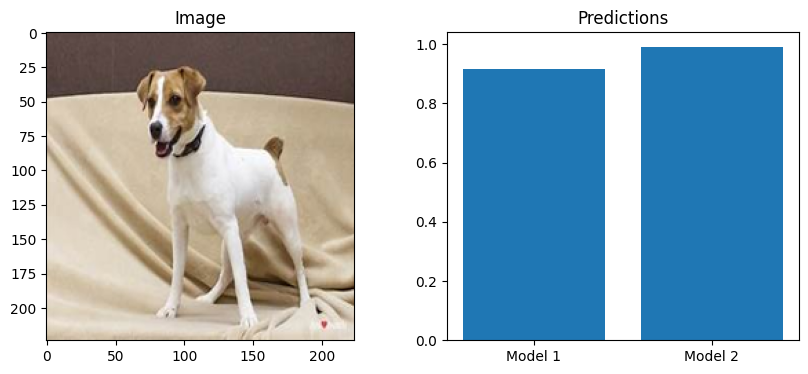

In [23]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title('Image')

plt.subplot(1, 2, 2)
plt.bar(['Model 1', 'Model 2'], 
        [pred1.item(), pred2.item()])
plt.title('Predictions')
plt.show()

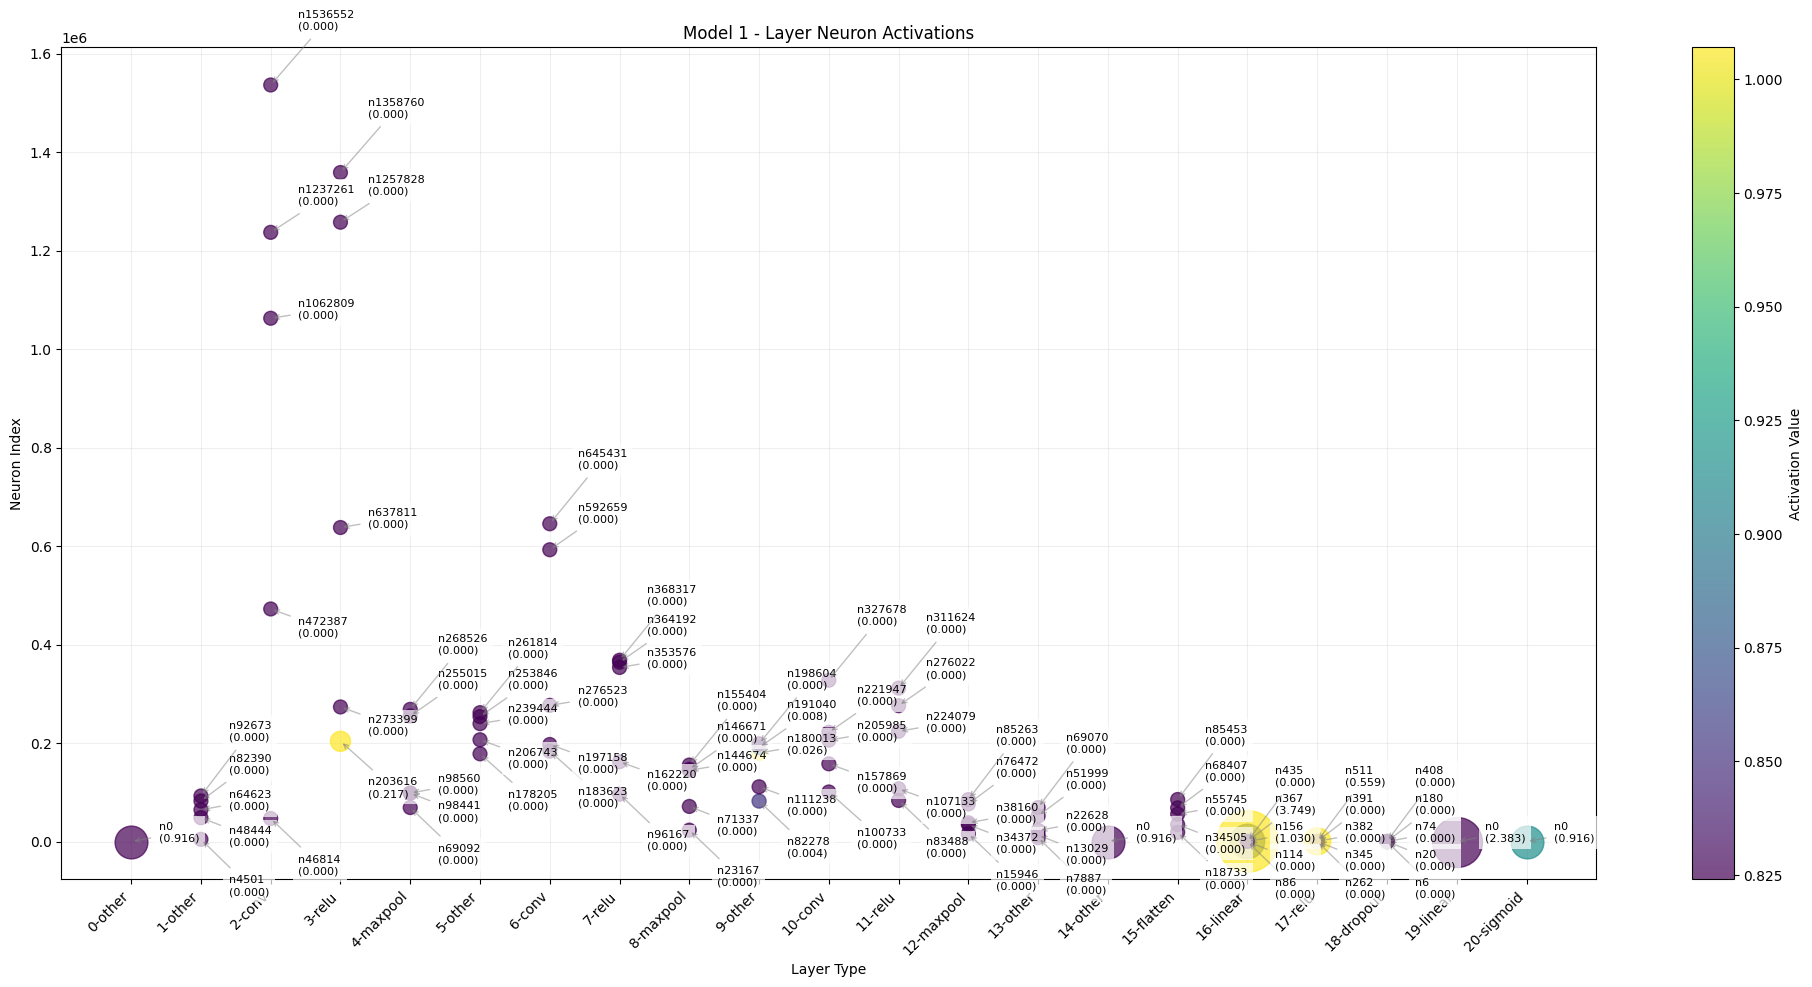

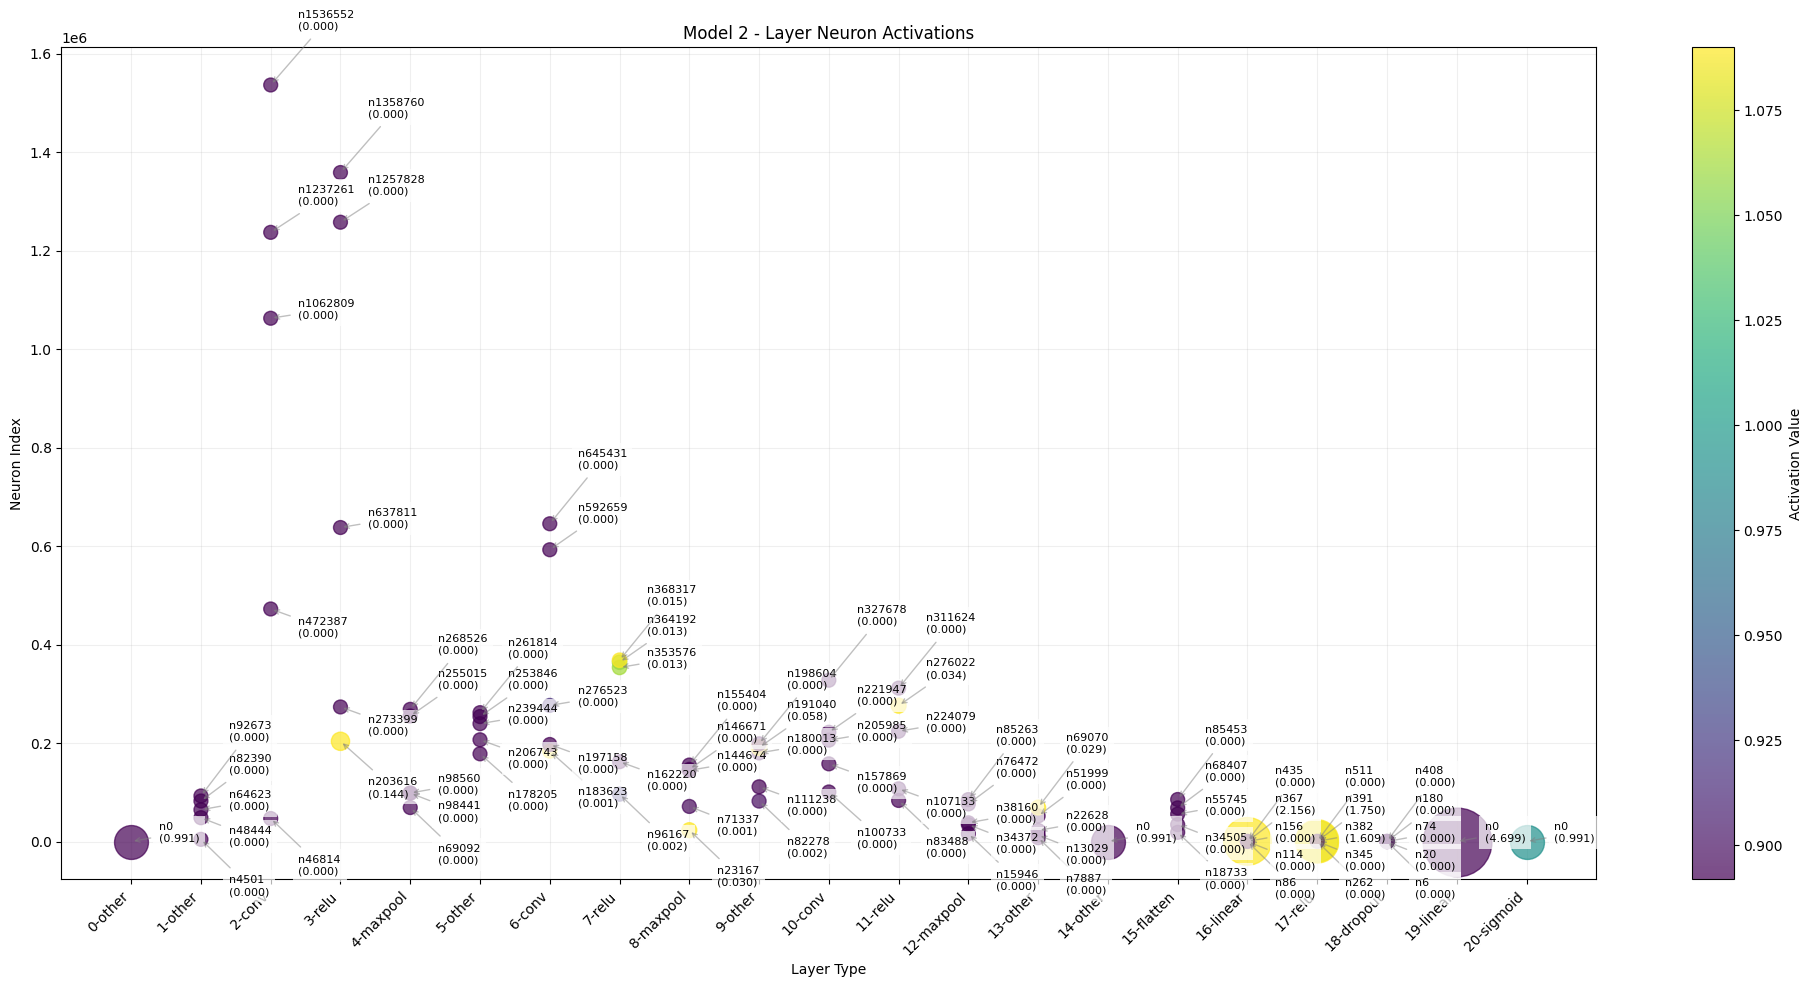

In [24]:
selected_indices = select_random_neuron_indices(activation_values["Model_1"], 
                                              layers1, 
                                              N_NEURONS)

permutation1 = get_activations_for_indices(activation_values["Model_1"], 
                                         selected_indices)
permutation2 = get_activations_for_indices(activation_values["Model_2"], 
                                         selected_indices)

df1= save_activations_to_csv(layers1, 'model1',permutation1, pic_index,  N_NEURONS)
df2 = save_activations_to_csv(layers2, 'model2',permutation2,pic_index, N_NEURONS)
# Plot activations for both models
plot_layer_neuron_activations(df1, 'Model 1',pic_index,N_NEURONS)
plot_layer_neuron_activations(df2, 'Model 2',pic_index,N_NEURONS)



In [137]:
# Remove hooks
for hook in hooks1 + hooks2:
    hook.remove()